In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

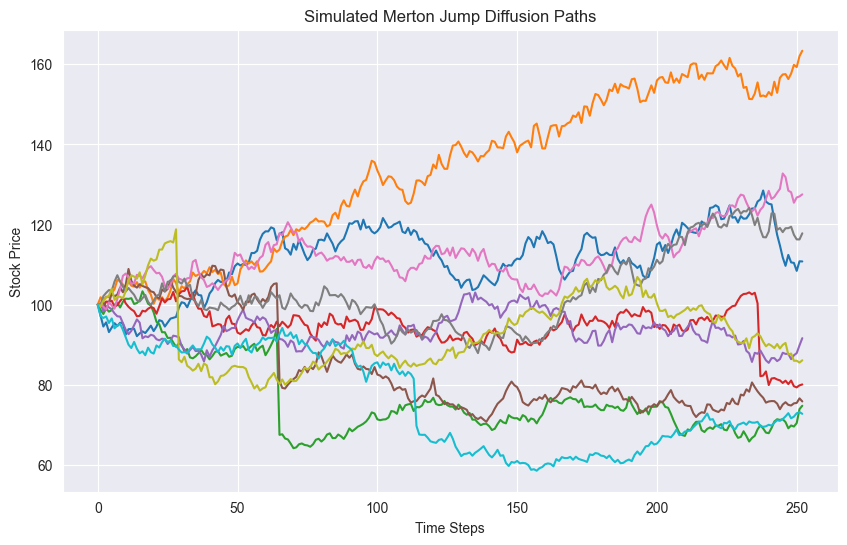

In [46]:


def merton_jump_diffusion(S0, r, sigma, lam, mu_J, sigma_J, T, trading_days, N):
    dt = 1 / trading_days  # Time increment based on trading days per year
    n_steps = int(T / dt)  # Number of time steps
    paths = np.zeros((n_steps + 1, N))
    paths[0] = S0

    # Precompute constants
    sqrt_dt = np.sqrt(dt)
    drift = (r - 0.5 * sigma ** 2) * dt

    # Simulate the paths
    for t in range(1, n_steps + 1):
        # Standard normal random numbers for GBM
        Z = np.random.standard_normal(N)
        
        # Poisson random numbers for jumps
        J = np.random.poisson(lam * dt, N)
        
        # Normally distributed jump sizes
        Y = np.random.normal(mu_J, sigma_J, N)
        
        # Calculate the compound jump component
        compound_jump = J * Y
        
        # Update the paths
        paths[t] = paths[t - 1] * np.exp(drift + sigma * sqrt_dt * Z + compound_jump)

    return paths

# Example parameters
S0 = 100             # Initial stock price
r = 0.05             # Risk-free rate
sigma = 0.2          # Volatility
lam = 1              # Jump frequency per year
mu_J = -0.1          # Mean of the jump size
sigma_J = 0.2       # Standard deviation of the jump size
T = 1                # Time horizon (1 year)
trading_days = 252   # Number of trading days in a year
N = 10              # Number of paths

# Generate the paths
price_paths = merton_jump_diffusion(S0, r, sigma, lam, mu_J, sigma_J, T, trading_days, N)

# Visualization
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(price_paths[:, i])
plt.title('Simulated Merton Jump Diffusion Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()


In [47]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import math

# Define the cumulative distribution function of a normal distribution
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    """
    Calculate the price of a European call option using the Black-Scholes formula.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.

    Returns:
    float: Price of the call option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r * T) * N(d2)

def BS_PUT(S, K, T, r, sigma):
    """
    Calculate the price of a European put option using the Black-Scholes formula.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.

    Returns:
    float: Price of the put option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * N(-d2) - S * N(-d1)

def merton_jump_call(S, K, T, r, sigma, mu_J, sigma_J, lam):
    """
    Calculate the price of a European call option using Merton's jump diffusion model.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.
    mu_J (float): Mean of the jump size.
    sigma_J (float): Standard deviation of the jump size.
    lam (float): Intensity of the Poisson jump process.

    Returns:
    float: Price of the call option.
    """
    price = 0
    m = np.exp(mu_J)  # Calculate m based on mu_J
    for k in range(40):  # Approximate the infinite series with first 40 terms
        r_k = r - lam * (m - 1) + (k * np.log(m)) / T
        sigma_k = np.sqrt(sigma ** 2 + (k * sigma_J ** 2) / T)
        k_fact = math.factorial(k)
        price += (np.exp(-m * lam * T) * (m * lam * T) ** k / k_fact) * BS_CALL(S, K, T, r_k, sigma_k)
    return price

def merton_jump_put(S, K, T, r, sigma, mu_J, sigma_J, lam):
    """
    Calculate the price of a European put option using Merton's jump diffusion model.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.
    mu_J (float): Mean of the jump size.
    sigma_J (float): Standard deviation of the jump size.
    lam (float): Intensity of the Poisson jump process.

    Returns:
    float: Price of the put option.
    """
    price = 0
    m = np.exp(mu_J)  # Calculate m based on mu_J
    for k in range(40):  # Approximate the infinite series with first 40 terms
        r_k = r - lam * (m - 1) + (k * np.log(m)) / T
        sigma_k = np.sqrt(sigma ** 2 + (k * sigma_J ** 2) / T)
        k_fact = math.factorial(k)
        price += (np.exp(-m * lam * T) * (m * lam * T) ** k / k_fact) * BS_PUT(S, K, T, r_k, sigma_k)
    return price


In [48]:
# fair value of call with strike 105 and put with strike 95, 1y maturity
S = 100
K_call = 105
K_put = 95
T = 1
r = 0.01
sigma = 0.5
m = 0.6
v = 0.2
lam = 0.1
    
call = merton_jump_call(S, K_call, T, r, sigma, m , v, lam)
put = merton_jump_put(S, K_put, T, r, sigma, m , v, lam)

print(f'Fair value of call option with strike {K_call} is {call:.2f}')
print(f'Fair value of put option with strike {K_put} is {put:.2f}')

Fair value of call option with strike 105 is 20.06
Fair value of put option with strike 95 is 17.96


In [49]:
import numpy as np
from scipy.stats import norm

N = norm.cdf

def BS_delta(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the delta of a European option.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.
    option_type (str): Type of the option ('call' or 'put').

    Returns:
    float: Delta of the option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        return N(d1)
    else:  # for put option
        return N(d1) - 1

def simulate_hedge(S_paths, K_call, K_put, r, sigma, T, dt):
    """
    Simulate delta hedging for call and put options along the price paths.

    Args:
    S_paths (numpy.ndarray): Simulated paths of the stock price.
    K_call (float): Strike price of the call option.
    K_put (float): Strike price of the put option.
    r (float): Risk-free rate.
    sigma (float): Volatility of the stock.
    T (float): Total time to maturity of the options.
    dt (float): Time step in years.

    Returns:
    np.ndarray: Array of the relative PnLs for each path.
    """
    n_steps = S_paths.shape[0]
    N = S_paths.shape[1]
    pnl = np.zeros(N)

    for i in range(N):
        cash = 0  # Initial cash position
        shares = 0  # Initial number of shares
        for t in range(n_steps - 1):
            S = S_paths[t, i]
            time_to_expiry = T - t * dt
            
            # Calculate deltas for both call and put
            delta_call = BS_delta(S, K_call, time_to_expiry, r, sigma, 'call')
            delta_put = BS_delta(S, K_put, time_to_expiry, r, sigma, 'put')
            
            # Net delta position from options
            net_delta = delta_call + delta_put
            
            # Adjust shares to hedge delta
            shares_change = -net_delta - shares
            shares -= shares_change  # Adjust shares to be delta neutral
            cash -= shares_change * S  # Adjust cash to reflect buying/selling shares
            
            # Update cash with risk-free interest rate
            cash *= np.exp(r * dt)
        
        # Final adjustment based on last stock price and option values
        final_stock_price = S_paths[-1, i]
        final_call_value = BS_CALL(final_stock_price, K_call, 0, r, sigma)
        final_put_value = BS_PUT(final_stock_price, K_put, 0, r, sigma)
        
        # Calculate final PnL
        pnl[i] = cash + shares * final_stock_price + final_call_value + final_put_value
    
    return pnl

# Example usage:
# Define simulation parameters
S0 = 100
r = 0.05
sigma = 0.2
lam = 1
mu_J = -0.1
sigma_J = 0.15
T = 1
trading_days = 252
num_paths = 100
K_call = 105
K_put = 95

# Simulate the underlying asset paths
price_paths = merton_jump_diffusion(S0, r, sigma, lam, mu_J, sigma_J, T, trading_days, num_paths)

# Simulate hedging
dt = 1 / trading_days
pnl = simulate_hedge(price_paths, K_call, K_put, r, sigma, T, dt)

# Analyzing the PnLs
print("Mean PnL:", np.mean(pnl))


C:\Users\fabia\AppData\Local\Temp\ipykernel_11500\2158885961.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
C:\Users\fabia\AppData\Local\Temp\ipykernel_11500\2158885961.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


Mean PnL: 3.870129391552841e+77


In [50]:
# Import necessary libraries
import numpy as np
from scipy.stats import norm

# Cumulative distribution function of a normal distribution
norm_cdf = norm.cdf

# Black-Scholes price for call
def BS_call_price(S, K, T, r, sigma):
    if T == 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm_cdf(d1) - K * np.exp(-r * T) * norm_cdf(d2)

# Black-Scholes price for put
def BS_put_price(S, K, T, r, sigma):
    if T == 0:
        return max(K - S, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm_cdf(-d2) - S * norm_cdf(-d1)

# Calculate relative P&L for delta hedging using Merton's model
def delta_hedging_PnL(S_paths, K_call, K_put, r, sigma, T):
    dt = T / (S_paths.shape[0] - 1)
    num_paths = S_paths.shape[1]
    relative_pnls = np.zeros(num_paths)

    for i in range(num_paths):
        S0 = S_paths[0, i]
        ST = S_paths[-1, i]
        
        # Initial and final option values
        V_call_start = BS_call_price(S0, K_call, T, r, sigma)
        V_put_start = BS_put_price(S0, K_put, T, r, sigma)
        V_call_end = BS_call_price(ST, K_call, 0, r, sigma)
        V_put_end = BS_put_price(ST, K_put, 0, r, sigma)

        # Portfolio values at start and end
        portfolio_start = V_call_start + V_put_start
        portfolio_end = V_call_end + V_put_end
        
        # Relative P&L calculation
        relative_pnls[i] = np.exp(-r * T) * (portfolio_end / portfolio_start)

    return relative_pnls

# Simulation parameters
S0 = 100
r = 0.05
sigma = 0.2
lam = 1
mu_J = -0.1
sigma_J = 0.15
T = 1
trading_days = 252
num_paths = 1000
K_call = 105
K_put = 95

# Simulate the underlying asset paths
price_paths = merton_jump_diffusion(S0, r, sigma, lam, mu_J, sigma_J, T, trading_days, num_paths)

# Calculate Relative P&L
relative_pnls = delta_hedging_PnL(price_paths, K_call, K_put, r, sigma, T)

# Print mean Relative P&L
print("Mean Relative P&L:", np.mean(relative_pnls))


Mean Relative P&L: 1.3107004677612435


In [51]:


def compute_rel_pl(Su, hedge, r, sigma, S0, lam, mu, del_, T, K, ttype, u):
    """
    Calculate the relative P&L of a hedge at time u.

    Args:
    Su (float): Terminal asset price.
    hedge (float): Hedge value at terminal time.
    r, sigma, S0, lam, mu, del_, T, K: Model parameters.
    ttype (str): Type of the option ('call' or 'put').
    u (float): Time at which the P&L is calculated.

    Returns:
    float: Relative P&L.
    """
    merton_val = merton_jump_call(Su, K, T-u, r, sigma, mu, del_, lam) if ttype == 'call' else merton_jump_put(Su, K, T-u, r, sigma, mu, del_, lam)
    if merton_val == 0:
        multiplier = 0  # Or some other appropriate default handling
    else:
        multiplier = np.exp(-r * u) / merton_val
    
    target = merton_jump_call(S0, K, T, r, sigma, mu, del_, lam) if ttype == 'call' else merton_jump_put(S0, K, T, r, sigma, mu, del_, lam)
    relPL = multiplier * (hedge - target)
    return relPL


# Example usage
Su = 80  # Terminal stock price
hedge = 0  # Value of hedge at terminal time
r = 0.05
sigma = 0.2
S0 = 100
lam = 1
mu = -0.1
del_ = 0.15
T = 1
K = 105
ttype = 'call'
u = 1  # Calculation at maturity

# Compute Relative P&L
#rel_pl = compute_rel_pl(Su, hedge, r, sigma, S0, lam, mu, del_, T, K, ttype, u)
#print("Relative P&L:", rel_pl)


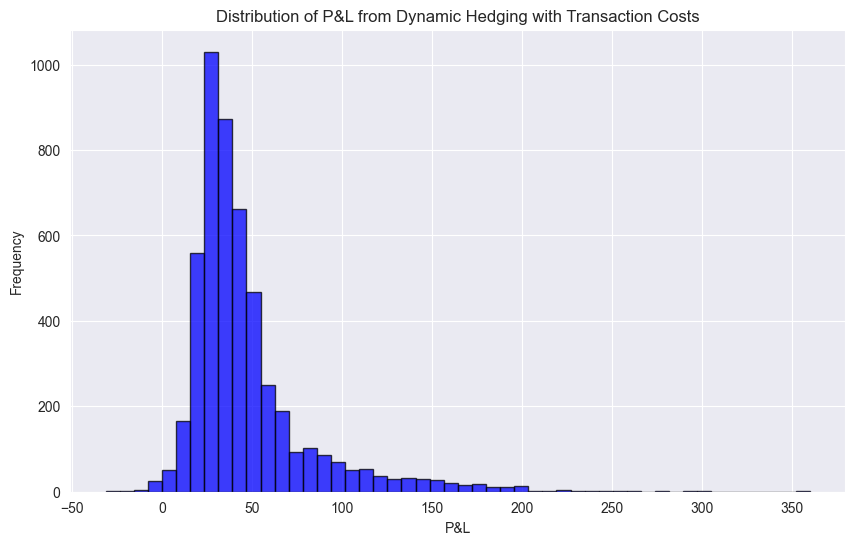

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def merton_price(S, K, T, r, sigma, lam, mu_J, sigma_J, option_type="call"):
    """ Simplified Merton model price of an option with jump diffusion """
    if option_type == "call":
        return merton_jump_call(S, K, T, r, sigma, mu_J, sigma_J, lam)
    elif option_type == "put":
        return merton_jump_put(S, K, T, r, sigma, mu_J, sigma_J, lam)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

def BS_delta(S, K, T, r, sigma):
    """ Black-Scholes delta calculation """
    if T <= 0:
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def dynamic_hedging(S_paths, K, r, sigma, lam, mu_J, sigma_J, T, rebalance_interval, transaction_cost_rate=0.01):
    n_steps, num_paths = S_paths.shape
    dt = T / (n_steps - 1)
    portfolio_values = np.zeros(num_paths)
    
    for path in range(num_paths):
        S0 = S_paths[0, path]
        cash = -merton_price(S0, K, T, r, sigma, lam, mu_J, sigma_J)  # Initial cost
        cash -= merton_price(S0, K, T, r, sigma, lam, mu_J, sigma_J, option_type="put")  # Initial cost
        shares = BS_delta(S0, K, T, r, sigma)  # Initial delta
        for step in range(1, n_steps):
            if step % rebalance_interval == 0 or step == n_steps - 1:
                new_shares = BS_delta(S_paths[step, path], K, T - step * dt, r, sigma)
                trade_amount = (new_shares - shares) * S_paths[step, path]
                cash -= trade_amount
                cash -= abs(trade_amount) * transaction_cost_rate  # Transaction costs
                shares = new_shares
            cash *= np.exp(r * dt)  # Interest on cash
            cash += shares * (S_paths[step, path] - S_paths[step - 1, path])  # Update from price change
        
        final_value = cash + shares * S_paths[-1, path] + max(S_paths[-1, path] - K, 0) + max(K - S_paths[-1, path], 0)
        portfolio_values[path] = final_value
    
    return portfolio_values

def plot_pnl_distribution(pnl_values):
    plt.figure(figsize=(10, 6))
    plt.hist(pnl_values, bins=50, alpha=0.75, color='blue', edgecolor='black')
    plt.title('Distribution of P&L from Dynamic Hedging with Transaction Costs')
    plt.xlabel('P&L')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Parameters
S0 = 100
K = 100
r = 0.0
sigma = 0.2
lam = 1
mu_J = -0.1
sigma_J = 0.15
T = 1
trading_days = 252
paths = 5000
rebalance_interval = 21  # Monthly rebalancing
transaction_cost_rate = 0.0  # 1% transaction cost

# Simulate and calculate P&L
S_paths = merton_jump_diffusion(S0, r, sigma, lam, mu_J, sigma_J, T, trading_days, paths)
portfolio_values = dynamic_hedging(S_paths, K, r, sigma, lam, mu_J, sigma_J, T, rebalance_interval, transaction_cost_rate)

# Plot distribution
plot_pnl_distribution(portfolio_values)


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

"""def merton_price(S, K, T, r, sigma, lam, mu_J, sigma_J):

    if T <= 0:
        return max(S - K, 0)  # Payoff at maturity
    n_terms = 50  # Number of terms in the series expansion
    price = 0
    m = np.exp(mu_J + 0.5 * sigma_J**2)  # Merton jump size factor
    for k in range(n_terms):
        r_k = r - lam * (m - 1) + (k * np.log(m)) / T
        sigma_k = np.sqrt(sigma**2 + k * sigma_J**2 / T)
        d1 = (np.log(S / K) + (r_k + 0.5 * sigma_k**2) * T) / (sigma_k * np.sqrt(T))
        d2 = d1 - sigma_k * np.sqrt(T)
        p_k = S * norm.cdf(d1) - K * np.exp(-r_k * T) * norm.cdf(d2)
        lambda_k = np.exp(-lam * T) * (lam * T)**k / np.math.factorial(k)
        price += lambda_k * p_k
    return price"""


def BS_delta(S, K, T, r, sigma):
    """ Black-Scholes delta calculation """
    if T <= 0:
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def dynamic_hedging(S_paths, K, r, sigma, lam, mu_J, sigma_J, T, rebalance_interval, transaction_cost_rate=0.01):
    n_steps, num_paths = S_paths.shape
    dt = T / (n_steps - 1)
    portfolio_values = np.zeros(num_paths)
    
    for path in range(num_paths):
        S0 = S_paths[0, path]
        cash = -merton_price(S0, K, T, r, sigma, lam, mu_J, sigma_J)  # Initial cost
        cash -= merton_price(S0, K, T, r, sigma, lam, mu_J, sigma_J, option_type="put")  # Initial cost
        shares = BS_delta(S0, K, T, r, sigma)  # Initial delta
        for step in range(1, n_steps):
            if step % rebalance_interval == 0 or step == n_steps - 1:
                new_shares = BS_delta(S_paths[step, path], K, T - step * dt, r, sigma)
                trade_amount = (new_shares - shares) * S_paths[step, path]
                cash -= trade_amount
                cash -= abs(trade_amount) * transaction_cost_rate  # Transaction costs
                shares = new_shares
            cash += shares * (S_paths[step, path] - S_paths[step - 1, path])  # Update from price change
        
        final_value = cash + shares * S_paths[-1, path] + max(S_paths[-1, path] - K, 0) + max(K - S_paths[-1, path], 0)
        portfolio_values[path] = final_value
    
    return portfolio_values


def dynamic_hedging(S_paths, K, r, sigma, lam, mu_J, sigma_J, T, rebalance_interval, transaction_cost_rate=0.01):
    n_steps, num_paths = S_paths.shape
    dt = T / (n_steps - 1)
    portfolio_values = np.zeros(num_paths)
    
    for path in range(num_paths):
        S0 = S_paths[0, path]
        cash = -merton_price(S0, K, T, r, sigma, lam, mu_J, sigma_J)  # Initial cost to buy the option
        cash -= merton_price(S0, K, T, r, sigma, lam, mu_J, sigma_J, option_type="put")  # Initial cost to buy the put option
        shares = BS_delta(S0, K, T, r, sigma) * S0  # Initial position in underlying asset
        share_count = BS_delta(S0, K, T, r, sigma)  # Initial delta hedging position

        for step in range(1, n_steps):
            S_current = S_paths[step, path]
            if step % rebalance_interval == 0 or step == n_steps - 1:
                new_share_count = BS_delta(S_current, K, T - step * dt, r, sigma)
                trade_amount = (new_share_count - share_count) * S_current
                cash -= trade_amount
                cash -= abs(trade_amount) * transaction_cost_rate  # Transaction costs
                share_count = new_share_count  # Update share count according to new delta
                shares = share_count * S_current  # Update total value of shares held

            # Update cash based on the change in share value (no interest on cash)
            cash += (share_count * S_current - shares)  # Gain or loss from holding shares
            shares = share_count * S_current  # Update shares to new stock price

        # Compute the final portfolio value
        final_stock_price = S_paths[-1, path]
        final_option_payoff = max(final_stock_price - K, 0)  + max(K - final_stock_price, 0)  # Option payoff at maturity put and call
        portfolio_values[path] = (cash + shares + final_option_payoff) / 1000  # Total value of the portfolio

    return portfolio_values 

def risk_metrics(portfolio_values, r, T):
    relative_pnl = np.mean(portfolio_values)
    std_dev = np.std(portfolio_values)
    sharpe_ratio = relative_pnl / std_dev * np.sqrt(252)  # Adjusted for no risk-free rate return
    
    confidence_levels = [0.9, 0.95, 0.99]
    VaR = {}
    CVaR = {}
    
    for level in confidence_levels:
        VaR[level] = np.percentile(portfolio_values, 100 * (1 - level))
        CVaR[level] = portfolio_values[portfolio_values <= VaR[level]].mean()
    
    return relative_pnl, VaR, CVaR, sharpe_ratio

def plot_pnl_distribution(pnl_values):
    plt.figure(figsize=(10, 6))
    plt.hist(pnl_values, bins=50, alpha=0.75, color='blue', edgecolor='black')
    plt.title('Distribution of P&L from Dynamic Hedging with Transaction Costs')
    plt.xlabel('P&L')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Parameters
S0 = 200
K = 200
r = 0.0
sigma = 0.2
lam = 0.1
mu_J = -0.9
sigma_J = 0.4
T = 1
trading_days = 512
paths = 5000
rebalance_interval = 21  # Monthly rebalancing
transaction_cost_rate = 0.00  # 1% transaction cost

Relative P&L: 0.0935909091744254
VaR: {0.9: 0.04067536487970741, 0.95: 0.03296550821615129, 0.99: -0.02910593959999698}
CVaR: {0.9: 0.01901728960735707, 0.95: 0.0004895929346562049, 0.99: -0.06658282460034012}
Sharpe Ratio: 21.254599858299915


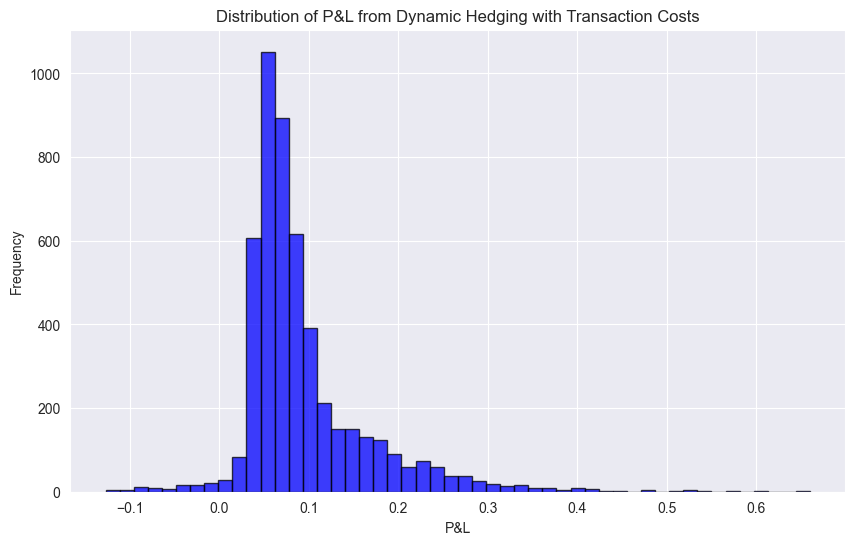

In [54]:

# Simulate and calculate P&L
S_paths = merton_jump_diffusion(S0, r, sigma, lam, mu_J, sigma_J, T, trading_days, paths)
portfolio_values = dynamic_hedging(S_paths, K, r, sigma, lam, mu_J, sigma_J, T, rebalance_interval, transaction_cost_rate)

# Calculate and print risk metrics
relative_pnl, VaRs, CVaRs, sharpe_ratio = risk_metrics(portfolio_values, r, T)
print("Relative P&L:", relative_pnl)
print("VaR:", VaRs)
print("CVaR:", CVaRs)
print("Sharpe Ratio:", sharpe_ratio)

# Plot distribution
plot_pnl_distribution(portfolio_values)


Relative P&L: 0.09667988566265533
VaR: {0.9: 0.04388450914712752, 0.95: 0.038805488606960585, 0.99: 0.030425383923316836}
CVaR: {0.9: 0.03759840421029524, 0.95: 0.03358171702595344, 0.99: 0.0267652436877709}
Sharpe Ratio: 22.205084762237334


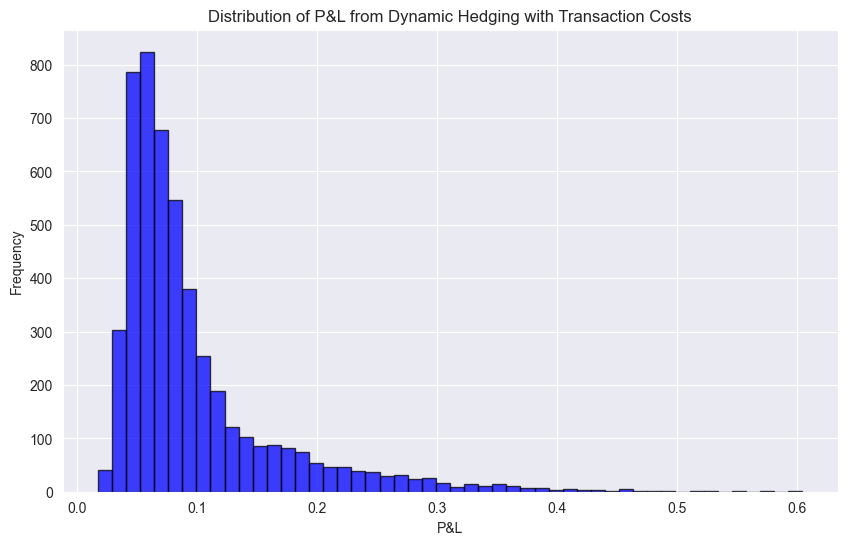

In [55]:
def black_scholes_paths(S0, r, sigma, T, trading_days, paths):
    """
    Generate stock price paths using the Black-Scholes model.

    Parameters:
    S0 (float): Initial stock price.
    r (float): Risk-free rate.
    sigma (float): Volatility of the stock.
    T (float): Time to maturity of the option.
    trading_days (int): Number of trading days in a year.
    paths (int): Number of paths to simulate.

    Returns:
    numpy.ndarray: Simulated stock price paths.
    """
    dt = T / trading_days  # Time step
    n_steps = int(T / dt)  # Total number of time steps
    S_paths = np.zeros((n_steps + 1, paths))
    S_paths[0] = S0

    # Generate paths
    for t in range(1, n_steps + 1):
        Z = np.random.standard_normal(paths)  # Draw standard normal random variables
        S_paths[t] = S_paths[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return S_paths



# Generate paths
bs_paths = black_scholes_paths(S0, r, sigma, T, trading_days, paths)
portfolio_values = dynamic_hedging(bs_paths, K, r, sigma, lam, mu_J, sigma_J, T, rebalance_interval, transaction_cost_rate)

# Calculate and print risk metrics
relative_pnl, VaRs, CVaRs, sharpe_ratio = risk_metrics(portfolio_values, r, T)
print("Relative P&L:", relative_pnl)
print("VaR:", VaRs)
print("CVaR:", CVaRs)
print("Sharpe Ratio:", sharpe_ratio)

# Plot distribution
plot_pnl_distribution(portfolio_values)


In [56]:
# run black scholes paths for 5 different rebalancing frequencies
rebalance_intervals = [2, 4, 8, 16, 32]
bs_paths = black_scholes_paths(S0, r, sigma, T, trading_days, paths)
# in the end i want 5 different pnl graphs in a single plot
vals = []
for rebalance_interval in rebalance_intervals:
    portfolio_values = dynamic_hedging(bs_paths, K, r, sigma, lam, mu_J, sigma_J, T, rebalance_interval, transaction_cost_rate)
    vals.append(portfolio_values)
    

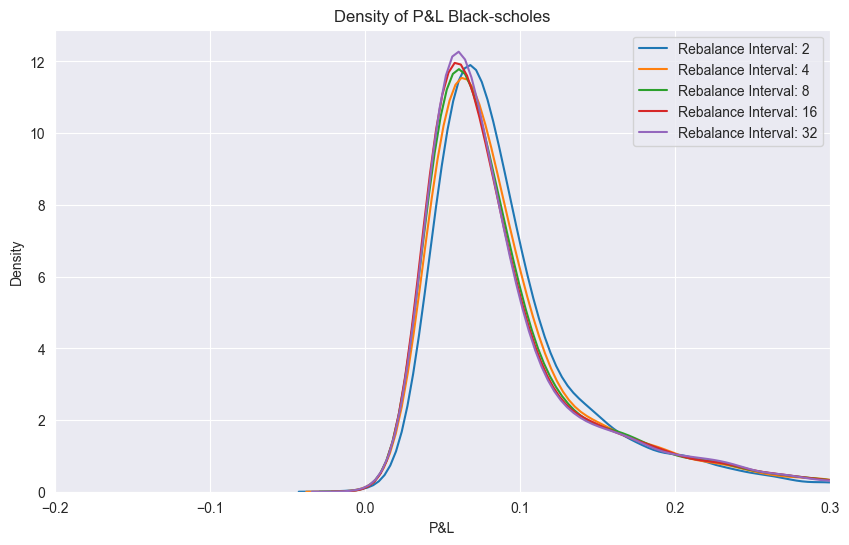

In [57]:
import scipy.stats as stats
import seaborn as sns
# plot only the density of the PnLs
plt.figure(figsize=(10, 6))
for i in range(len(vals)):
    sns.kdeplot(vals[i], label=f'Rebalance Interval: {rebalance_intervals[i]}')
    #plt.hist(vals[i], bins=500, alpha=0.75, label=f'Rebalance Interval: {rebalance_intervals[i]}', histtype="step")
plt.title('Density of P&L Black-scholes')
plt.xlim(-0.2, 0.3)
plt.xlabel('P&L')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()



In [58]:
# run jump diffusion paths for 5 different rebalancing frequencies

jd_paths = merton_jump_diffusion(S0, r, sigma, lam, mu_J, sigma_J, T, trading_days, paths)
# in the end i want 5 different pnl graphs in a single plot
vals = []
for rebalance_interval in rebalance_intervals:
    portfolio_values = dynamic_hedging(jd_paths, K, r, sigma, lam, mu_J, sigma_J, T, rebalance_interval, transaction_cost_rate)
    vals.append(portfolio_values)
    
    

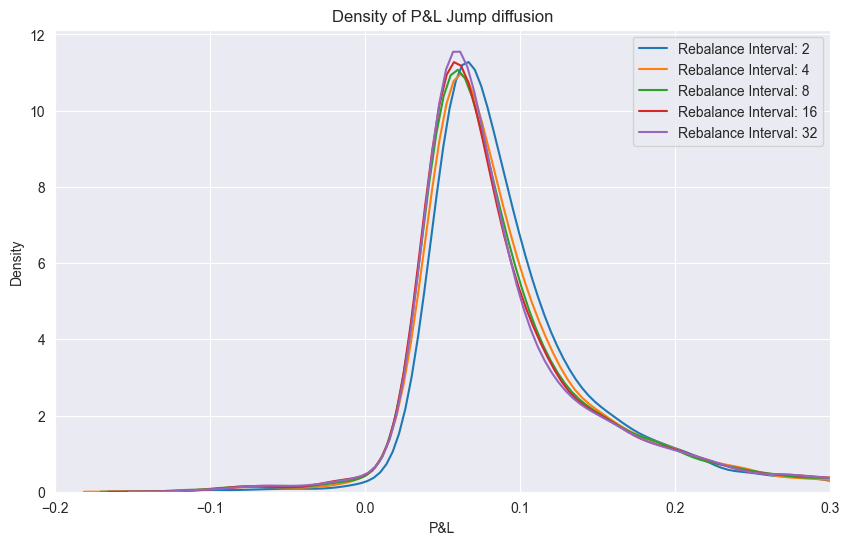

In [59]:
# plot only the density of the PnLs
plt.figure(figsize=(10, 6))
for i in range(len(vals)):
    sns.kdeplot(vals[i], label=f'Rebalance Interval: {rebalance_intervals[i]}')
    
plt.title('Density of P&L Jump diffusion')
plt.xlim(-0.2, 0.3)
plt.xlabel('P&L')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

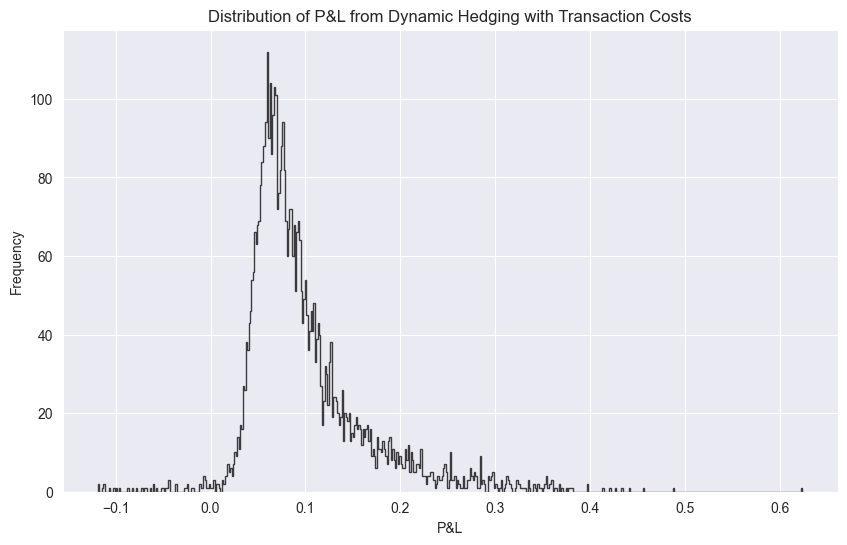

In [60]:
# plot vals[0]
plt.figure(figsize=(10, 6))
plt.hist(vals[0], bins=500, alpha=0.75, color='blue', edgecolor='black', histtype="step")
plt.title('Distribution of P&L from Dynamic Hedging with Transaction Costs')
plt.xlabel('P&L')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [61]:
import numpy as np

def black_scholes_paths(S0, r, sigma, T, trading_days, paths):
    dt = T / trading_days  # Time step
    n_steps = int(T / dt)  # Total number of time steps
    S_paths = np.zeros((n_steps + 1, paths))
    S_paths[0] = S0

    for t in range(1, n_steps + 1):
        Z = np.random.standard_normal(paths)  # Draw standard normal random variables
        S_paths[t] = S_paths[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return S_paths

def european_option_pnl(S_paths, K, r, T, option_type='call'):
    """
    Calculate the relative P&L for European options using simulated paths.

    Parameters:
    S_paths (numpy.ndarray): Simulated stock price paths.
    K (float): Strike price of the option.
    r (float): Risk-free rate.
    T (float): Time to maturity of the option.
    option_type (str): Type of the option ('call' or 'put').

    Returns:
    dict: Dictionary containing mean P&L, std P&L, and list of P&Ls.
    """
    # Calculate the payoff
    if option_type == 'call':
        payoffs = np.maximum(S_paths[-1] - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - S_paths[-1], 0)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

    # Discount the payoffs to present value
    discounted_payoffs = np.exp(-r * T) * payoffs

    # Calculate initial option price using Black-Scholes formula for either call or put
    if option_type == 'call':
        d1 = (np.log(S_paths[0] / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        initial_price = S_paths[0] * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        d1 = (np.log(S_paths[0] / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        initial_price = K * np.exp(-r * T) * norm.cdf(-d2) - S_paths[0] * norm.cdf(-d1)

    # Calculate relative P&L for each path
    relative_pnl = discounted_payoffs / initial_price - 1

    # Gather statistics
    mean_pnl = np.mean(relative_pnl)
    std_pnl = np.std(relative_pnl)
    pnl_list = relative_pnl.tolist()

    return {'mean_pnl': mean_pnl, 'std_pnl': std_pnl, 'pnl_list': pnl_list}

# Example usage
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1
trading_days = 1000
paths = 1000

bs_paths = black_scholes_paths(S0, r, sigma, T, trading_days, paths)
pnl_data = european_option_pnl(bs_paths, K, r, T, option_type='call')

print("Mean P&L:", pnl_data['mean_pnl'])
print("Std P&L:", pnl_data['std_pnl'])


Mean P&L: 0.01659490077694455
Std P&L: 1.3946261801686475
